# 공간 조인 (Spatial Join)

---

&emsp;<i>공간 조인(Spatial joins)</i>은 둘 이상의 공간 데이터를 기하학적 관계에 기반하여 결합하는 작업을 일컫습니다. 이전 단원에서 공간 조인 중 <a href="./3.3. Point-In-Polygon 쿼리.ipynb">PIP (Point-In-Polygon) 쿼리</a>와 <a href="./3.4. 교차.ipynb">교차(intersects) 쿼리</a>를 다뤘습니다. 이 외에도 기하학적 관계에 기반해 작업할 수 있는 공간 조인의 종류에 대해 살펴보겠습니다.  

&emsp;공간 조인 작업에는 두 개의 파라미터가 필요합니다. 첫번째 파라미터는 두 도형 사이에 충족해야 하는 기하학적 조건을 명시한 <i>predicament (조인 종류)</i> 입니다. 두번째 파라미터는 <i>join-type (조인 유형)</i> 입니다. join-type (조인 유형)은 predicate를 만족하는 행만 유지되는지 또는 한 도형의 모든 행이 유지되는지 또는 두 도형의 모든 행이 유지되는지를 선택할 수 있는 옵션입니다. 두 파라미터에 대해서 잘 이해가 되지 않을 수도 있습니다. 아래 예시를 통해 자세히 살펴보면서 이해할 수 있도록 합니다.  

&emsp;<i>Geopandas</i>는 GIS 프로그램에서 대표적으로 많이 사용되는 [공간 조인 predicate](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#binary-predicate-joins)를 지원합니다. Predicate는 일반적인 영어 동사로 표현되므로 직관적입니다. 각 predicate에 대한 자세한 설명은 [shapely 공식 문서](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)를 참조하시길 바랍니다.

- 교차 (intersects)
- 포함 (contains) / 내부 (within)
- 접촉 (touches)
- 횡단 (crosses)
- 겹침 (overlaps)  

&emsp;<i>Join-type (조인 유형)</i>은 geopandas에서 3 가지 옵션을 구현합니다.  

- <i>left</i> : 왼쪽 데이터프레임의 모든 행 유지. 매칭되지 않는 경우 빈 값(empty value)으로 채움. 왼쪽 데이터프레임의 geometry 열 유지
- <i>right</i> : 오른쪽 데이터프레임의 모든 행 유지. 매칭되지 않는 경우 빈 값(empty value)으로 채움. 오른쪽 데이터프레임의 geometry 열 유지
- <i>inner</i> : 매칭되는 행만 유지, 왼쪽 데이터프레임의 geometry 열 유지  

```{tip}
&emsp;[PyGIS 책](https://pygis.io/docs/e_spatial_joins.html)에서 공간 조인 predicate와 join-type에 대한 그림 설명을 참고할 수 있습니다.  
```

## 입력 데이터 불러오기

&emsp;이번 단원에서 공간 조인을 실습하기 위해, 이전 단원에서 사용한 주소 데이터와 인구 격자(grid) 데이터를 결합하여 주소별 인구 밀도 데이터를 만들어 보겠습니다. 여기에서 사용하게 될 인구 격자 데이터는 [국토정보플랫폼](https://map.ngii.go.kr/mn/mainPage.do)의 국토통계지도에서 다운로드 받을 수 있습니다.

In [1]:
import pathlib

NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas as gpd

addresses = gpd.read_file(DATA_DIRECTORY / "addresses.gpkg")
population_grid = gpd.read_file(DATA_DIRECTORY / "국토통계_인구정보_1KM_서울특별시_202304", encoding="utf-8")

In [3]:
population_grid.head()

,gid,lbl,val,geometry
0,다사6453,9172.00,9172.0,"POLYGON ((964000.000 1953000.000, 964000.000 1..."
1,다사5651,12198.00,12198.0,"POLYGON ((956000.000 1951000.000, 956000.000 1..."
2,다사6157,28897.00,28897.0,"POLYGON ((961000.000 1957000.000, 961000.000 1..."
3,다사5858,23351.00,23351.0,"POLYGON ((958000.000 1958000.000, 958000.000 1..."
4,다사5347,11380.00,11380.0,"POLYGON ((953000.000 1947000.000, 953000.000 1..."


&emsp;인구 격자 데이터는 `gid`, `lbl`, `val`, `geometry` 4개의 열로 구성되어 있습니다. 여기에서 사용할 인구 열 `val`과 위치정보 열 `geometry`를 제외하고 나머지 열들을 제거해 줍니다.

In [4]:
population_grid = population_grid[["val", "geometry"]]
population_grid.head()

,val,geometry
0,9172.0,"POLYGON ((964000.000 1953000.000, 964000.000 1..."
1,12198.0,"POLYGON ((956000.000 1951000.000, 956000.000 1..."
2,28897.0,"POLYGON ((961000.000 1957000.000, 961000.000 1..."
3,23351.0,"POLYGON ((958000.000 1958000.000, 958000.000 1..."
4,11380.0,"POLYGON ((953000.000 1947000.000, 953000.000 1..."


&emsp;각 격자 셀의 주민 수를 면적(km²)으로 나누어 인구 밀도를 계산합니다.

In [5]:
population_grid["population_density"] = population_grid["val"] / (population_grid.area / 1_000_000)
population_grid.head()

,val,geometry,population_density
0,9172.0,"POLYGON ((964000.000 1953000.000, 964000.000 1...",9172.0
1,12198.0,"POLYGON ((956000.000 1951000.000, 956000.000 1...",12198.0
2,28897.0,"POLYGON ((961000.000 1957000.000, 961000.000 1...",28897.0
3,23351.0,"POLYGON ((958000.000 1958000.000, 958000.000 1...",23351.0
4,11380.0,"POLYGON ((953000.000 1947000.000, 953000.000 1...",11380.0


## 입력 레이어 조인 (join)

&emsp;이제 여러분은 두 레이어 `addresses`와 `population_grid`에 공간 조인을 수행할 준비가 되었습니다. 이번 작업의 목표는 각 주소 지점 주변의 인구 밀도를 탐색하는 것입니다. 그러기 위해서는 `population_grid` 데이터의 인구 밀도(다각형 레이어)를 `addresses` 데이터의 주소 지점(점 레이어)에 결합시켜야 합니다. 그 후, **다각형 내부에 점이 위치**하는지 판단하여 점이 위치한 해당 다각형의 인구 밀도 정보를 사용하면 됩니다. 따라서 이 작업에서는 **주소 지점(점 레이어)의 `geometry` 열을 유지**해야 합니다.  

&emsp;공간 조인을 진행하기 전에 두 레이어가 동일한 CRS (Cartographic Reference System; 지도제작 참조 시스템)에 있는지 확인해야 합니다.  

In [6]:
assert addresses.crs == population_grid.crs, f"두 레이어의 CRS가 동일하지 않습니다.\n addresses : {addresses.crs}\n population_grid : {population_grid.crs}"

AssertionError: 두 레이어의 CRS가 동일하지 않습니다.
 addresses : EPSG:4326
 population_grid : PROJCS["Korea 2000 / Unified CS",GEOGCS["Korea 2000",DATUM["Geocentric_datum_of_Korea",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["central_meridian",127.5],PARAMETER["latitude_of_origin",38],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1000000],PARAMETER["false_northing",2000000],UNIT["m",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5179"]]

&emsp;위와 같이 두 레이어의 CRS가 동일하지 않다는 것을 확인했습니다. `addresses`의 CRS인 EPSG:4326을 사용하여 `population_grid`를 재투영(reproject) 하겠습니다.

In [7]:
population_grid = population_grid.to_crs(addresses.crs)

&emsp;이제 [`geopandas.GeoDataFrame.sjoin()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html) 메서드를 사용하여 공간 조인을 수행할 준비가 되었습니다. 여러분은 *within* predicate를 사용하고, 점 레이어의 geometry 열을 유지해야 합니다.  

In [8]:
addresses_with_population_data = addresses.sjoin(population_grid, predicate="within", how="left")
addresses_with_population_data.head()

,address,지점,지점주소,geometry,index_right,val,population_density
0,"서울특별시아동학대예방센터, 광평로34길, 06352, 광평로34길, 서울, 대한민국",400,서울특별시 강남구 일원동 580,POINT (127.08775 37.47971),500.0,16080.0,16080.0
1,"서울특별시데이터센터, 남부순환로340길, 06724, 남부순환로340길, 서울, 대한민국",401,서울특별시 서초구 서초동 1416번지,POINT (127.02191 37.47954),298.0,8109.0,8109.0
2,"서울특별시 동부기술교육원, 183, 고덕로, 05235, 고덕로, 고덕동, 대한민국",402,서울특별시 강동구 고덕로 183,POINT (127.14557 37.55604),78.0,39764.0,39764.0
3,"롯데월드, 240, 올림픽로, 05554, 올림픽로, 잠실동, 대한민국",403,서울특별시 송파구 올림픽로 240,POINT (127.09824 37.51150),367.0,24798.0,24798.0
4,"월드메르디앙 201동, 양천로1길, 07602, 양천로1길, 서울, 대한민국",404,서울특별시 강서구 양천로 201,POINT (126.81027 37.57468),394.0,21722.0,21722.0


&emsp;위와 같이 인구 밀도 정보가 첨부된 주소 데이터셋을 만들었습니다. 제작된 데이터셋을 사용해 지도 위에 시각화 해보겠습니다.  

&emsp;`geopandas.GeoDataFrame.plot()` 메서드는 시각화하고자 하는 열 이름을 `column` 인수(argument)에 전달하여 그라데이션 색으로 해당 열의 값을 지도 상에 표현할 수 있습니다. 또한 지도 스타일과 관련된 다양한 인수들을 사용해 여러분이 원하는 색상, 스타일로 시각화할 수 있습니다. 이러한 대표적인 인수로는 범주화 체계(categorisation scheme)를 정의하는 `scheme`과 [색상 맵(colour map)](https://matplotlib.org/stable/tutorials/colors/colormaps.html)을 설정하는 `cmap`이 있습니다. `matplotlib`에서 사용되는 인수들을 공통적으로 사용할 수 있습니다. 예를 들어, 마커(marker)의 크기를 설정하는 `markersize`, 다각형 영역 색상을 설정하는 `facecolor`와 같은 인수가 있습니다. 이 외에도 범례(legend)를 그리려면 `legend`를 `True`로 설정하고, 그림의 크기를 설정하려면 가로·세로 인치(inch) 값으로 구성된 튜플(tuple)을 인수 `figsize`에 전달합니다.

In [10]:
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")

Text(0.5, 1.0, '주소 지점 인근 인구 밀도')

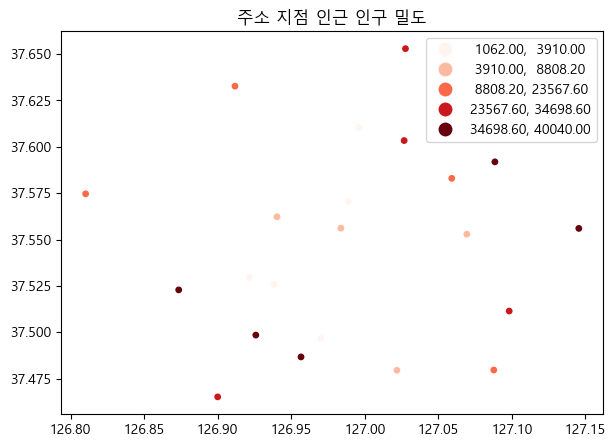

In [11]:
ax = addresses_with_population_data.plot(
    figsize=(7, 7),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    markersize=15,
    legend=True
)
ax.set_title("주소 지점 인근 인구 밀도")

&emsp;동일한 인수를 적용하여 전체 `population_grid` 데이터셋의 인구 밀도 지도를 그릴 수 있습니다.

Text(0.5, 1.0, '서울 인구 밀도')

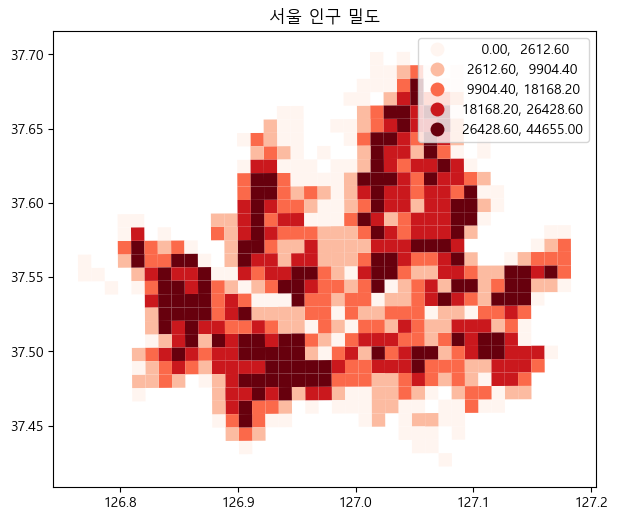

In [12]:
ax = population_grid.plot(
    figsize=(7, 7),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    legend=True
)
ax.set_title("서울 인구 밀도")

&emsp;마지막으로 여러분이 공간 조인한 데이터프레임 `addresses_with_population_data`를 파일에 저장하는 것으로 마무리하겠습니다. 새로운 레이어 이름을 지정하여 기존 *GeoPackage* 파일 `addresses.gpkg`에 추가할 수도 있습니다.

In [13]:
addresses_with_population_data.to_file(
    DATA_DIRECTORY / "addresses.gpkg",
    layer="addresses_with_population_data"
)

---

```{raw} html
<script src="https://utteranc.es/client.js"
        repo="Kwan-Gu/geospatial_analysis"
        issue-term="pathname"
        theme="preferred-color-scheme"
        crossorigin="anonymous"
        async>
</script>
```